In [1]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
import subprocess
from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

random.seed(165)

In [8]:
# DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*" # <- needs to be normalized
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*" # <- needs to be normalized
DATA_PATH = "/home/satyarth934/data/proxy_data/UCMerced_LandUse/Images/*/*"

MODEL_NAME = "baseAE_uc_merced"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"
NORMALIZE = False
SAVE_FILES = True

OUTPUT_MODEL_PATH = BASE_DIR + "Models/" + MODEL_NAME
TENSORBOARD_LOG_DIR = BASE_DIR + "tb_logs/" + MODEL_NAME
ACTIVATION_IMG_PATH = BASE_DIR + "activation_viz/" + MODEL_NAME

FEATURES_PARENT_DIR = BASE_DIR + "Features/" + MODEL_NAME
PATH_LIST = FEATURES_PARENT_DIR + "/filenames.pkl"
FEATURES_OUTPUT = FEATURES_PARENT_DIR + "/features.pkl"

# NUM_EPOCHS = 200

# dust_labels = {0: "Dust", 1: "Hazy", 2: "No Dust"}

In [9]:
X_test_paths = pickle.load(file=open((PATH_LIST), 'rb'))
feature_list = pickle.load(file=open((FEATURES_OUTPUT), 'rb'))

In [10]:
num_images = len(X_test_paths)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  420
Number of features per image =  3920


In [11]:
# Use scikit-learn to find Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=50,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

In [12]:
def classname(str):
    return str.split("/")[-2]


# Helper function to get the classname and filename
def classname_filename(filepath):
    return str(classname(filepath)) + '/' + filepath.split('/')[-1]


# Normalize the image to plot
def normalize(mat):
    normalized = (mat - np.nanmin(mat)) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances, dims):
    images = []
    for filename in filenames:
        np_img = resize(plt.imread((filename))[:,:,:3], dims)
        if NORMALIZE:
            np_img = normalize(np_img)
        
        images.append(np_img)
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        if SAVE_FILES:
            file_parent = BASE_DIR + "Features/Images/" + MODEL_NAME
            subprocess.call("mkdir -p " + file_parent, shell=True)
            output_path = file_parent + "/similar_%s_%s.pdf" % (filenames[i].split('/')[-1].split(".")[1], classname(filenames[i]))
            plt.savefig(output_path, format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

247
[247 230 216 156  90 299 183 213 154 223 112 148 290  85 212]
[0.0, 0.75, 0.75, 0.76, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.79, 0.8, 0.8, 0.8, 0.8]
[0.0, 0.75, 0.75, 0.76, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.79, 0.8, 0.8, 0.8, 0.8]
['sparseresidential72.tif', 'forest95.tif', 'forest59.tif', 'forest93.tif']


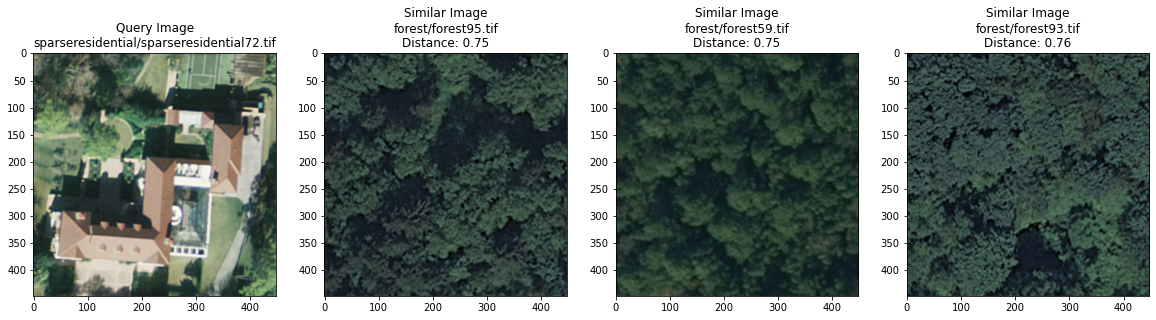

411
[411 384 183  90 359 271 223 216 212 230 299 290 154  85 156]
[0.0, 0.63, 0.64, 0.65, 0.66, 0.66, 0.66, 0.66, 0.67, 0.67, 0.67, 0.68, 0.68, 0.68, 0.69]
[0.0, 0.63, 0.64, 0.65, 0.66, 0.66, 0.66, 0.66, 0.67, 0.67, 0.67, 0.68, 0.68, 0.68, 0.69]
['denseresidential46.tif', 'forest83.tif', 'forest90.tif', 'river96.tif']


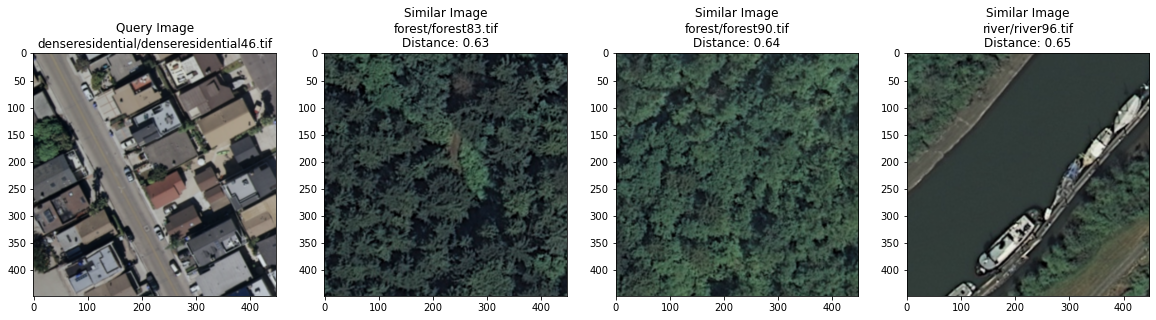

402
[402 223 299 230 154 384 150 290 216 213 156  90 183 212 112]
[0.0, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89]
[0.0, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89]
['mobilehomepark54.tif', 'forest80.tif', 'forest52.tif', 'forest95.tif']


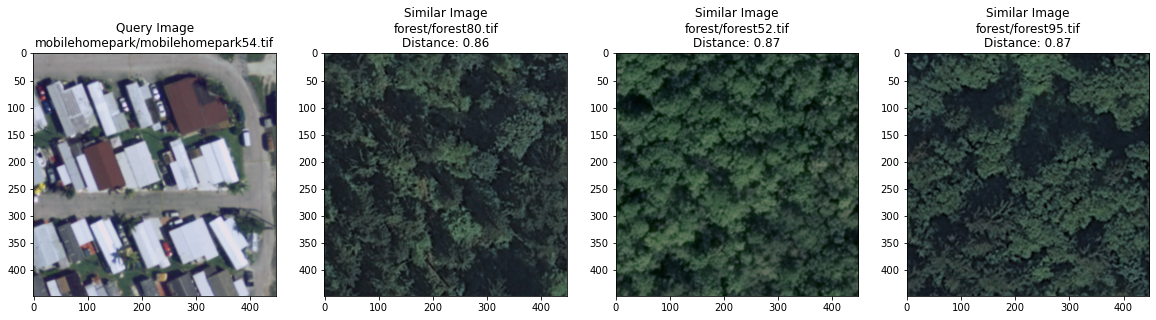

29
[ 29 212 359 216 183 384 299 230 112  85 154 213 223 156 290]
[0.0, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91]
[0.0, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91]
['mobilehomepark18.tif', 'forest84.tif', 'forest55.tif', 'forest59.tif']


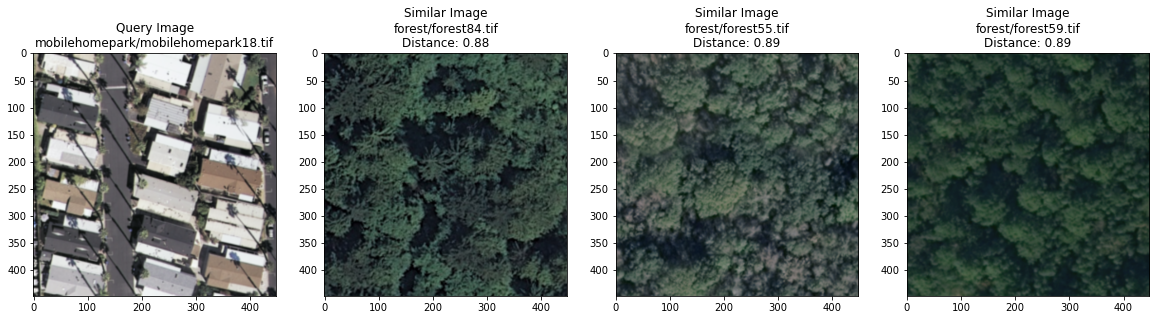

101
[101 112  90 359 216 183 337 212 299 213 148 230 154 223 384]
[0.0, 0.72, 0.76, 0.76, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.79, 0.79]
[0.0, 0.72, 0.76, 0.76, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.79, 0.79]
['mediumresidential81.tif', 'forest44.tif', 'river96.tif', 'forest55.tif']


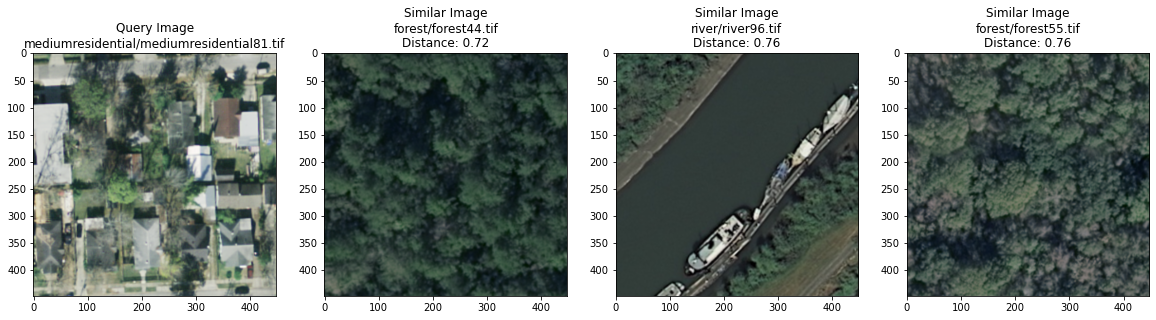

34
[ 34 271 153 228 267 240 299 205 154 382 384 290 226 183 223]
[0.0, 0.8, 0.81, 0.84, 0.84, 0.86, 0.86, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88]
[0.0, 0.8, 0.81, 0.84, 0.84, 0.86, 0.86, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88]
['overpass01.tif', 'baseballdiamond76.tif', 'runway05.tif', 'river34.tif']


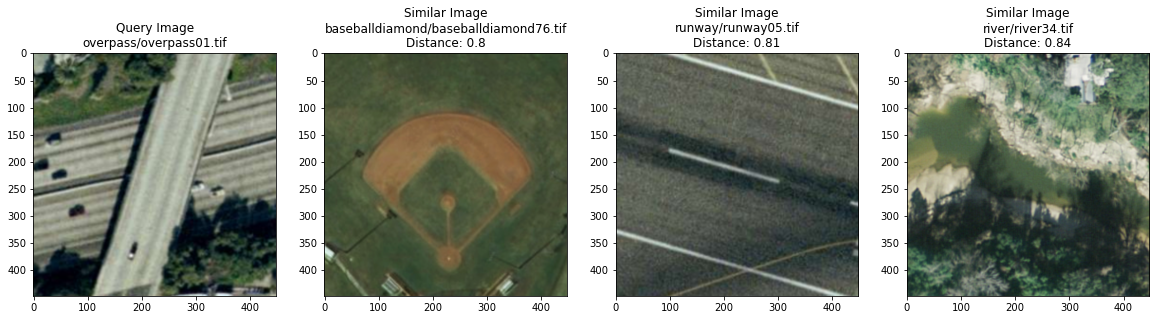

In [14]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
#     random_image_index = 142
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    print(random_image_index)
    print(indices[0][:15])
    print([float("%.2f"%d) for d in distances[0][:15]])
    
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [X_test_paths[random_image_index]] + [X_test_paths[indices[0][i]] for i in range(1, 4)]
    pprint([p.split("/")[-1] for p in similar_image_paths])
    plot_images(similar_image_paths, distances[0], dims=(448, 448, 3))
    plt.show()

In [15]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.0658934
Max distance between all photos:  1.365122
Median distance among most similar photos:  0.7858565


In [18]:
selected_features = feature_list[:]
selected_class_ids = [classname(f) for f in X_test_paths[:]]
selected_filenames = X_test_paths[:]

print(len(selected_features))
print(len(selected_class_ids))
print(len(selected_filenames))

# colors = [b,g,r,c,m,y,k,w]
color_class_map = {}
color = 0x000000
for cid in selected_class_ids:
    if cid not in color_class_map:
        color += 100
        color_class_map[cid] = color
print(color_class_map)

selected_class_ids = [color_class_map[cid] for cid in selected_class_ids]

# print(selected_class_ids)

420
420
420
{'freeway': 100, 'agricultural': 200, 'mobilehomepark': 300, 'denseresidential': 400, 'tenniscourt': 500, 'buildings': 600, 'runway': 700, 'sparseresidential': 800, 'baseballdiamond': 900, 'river': 1000, 'storagetanks': 1100, 'airplane': 1200, 'overpass': 1300, 'harbor': 1400, 'chaparral': 1500, 'mediumresidential': 1600, 'beach': 1700, 'intersection': 1800, 'forest': 1900, 'parkinglot': 2000, 'golfcourse': 2100}


In [19]:
import time
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 30
n_iter = 1000
metric = 'euclidean'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(selected_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 420 samples in 0.068s...
[t-SNE] Computed neighbors for 420 samples in 1.215s...
[t-SNE] Computed conditional probabilities for sample 420 / 420
[t-SNE] Mean sigma: 0.235788
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.050873
[t-SNE] KL divergence after 1000 iterations: 1.263738
t-SNE done! Time elapsed: 2.4358785152435303 seconds


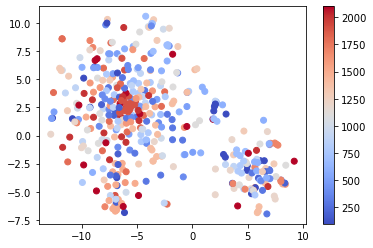

In [20]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=selected_class_ids,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.savefig(FEATURES_PARENT_DIR + "/tSNE_scatter.png")
plt.show()
# To save the plot in a high definition format i.e. PDF, uncomment the following line:


In [21]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

dims=(448, 448, 3)
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.fromarray(np.uint8(resize(plt.imread((image_path))[:,:,:3], dims)*255))
#         image = Image.fromarray(np.uint8(np.load(image_path)*255))
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [22]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_scatter.png")
    plt.show()

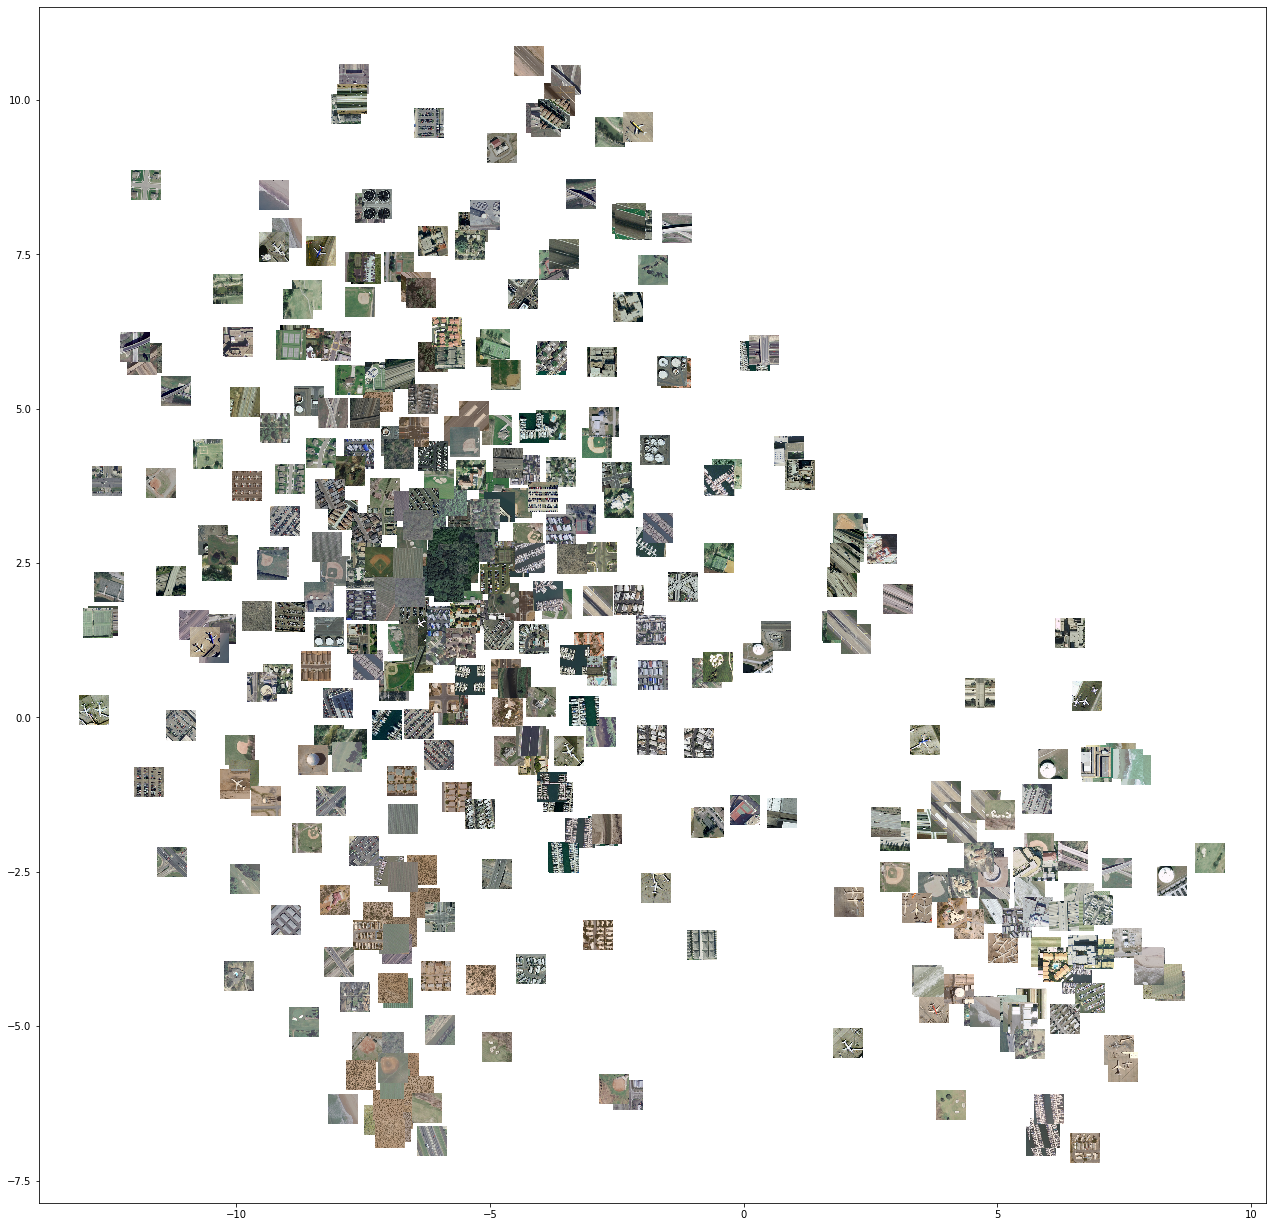

In [23]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [24]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.savefig(FEATURES_PARENT_DIR + "/tSNE_img_grid.png")
    plt.show()

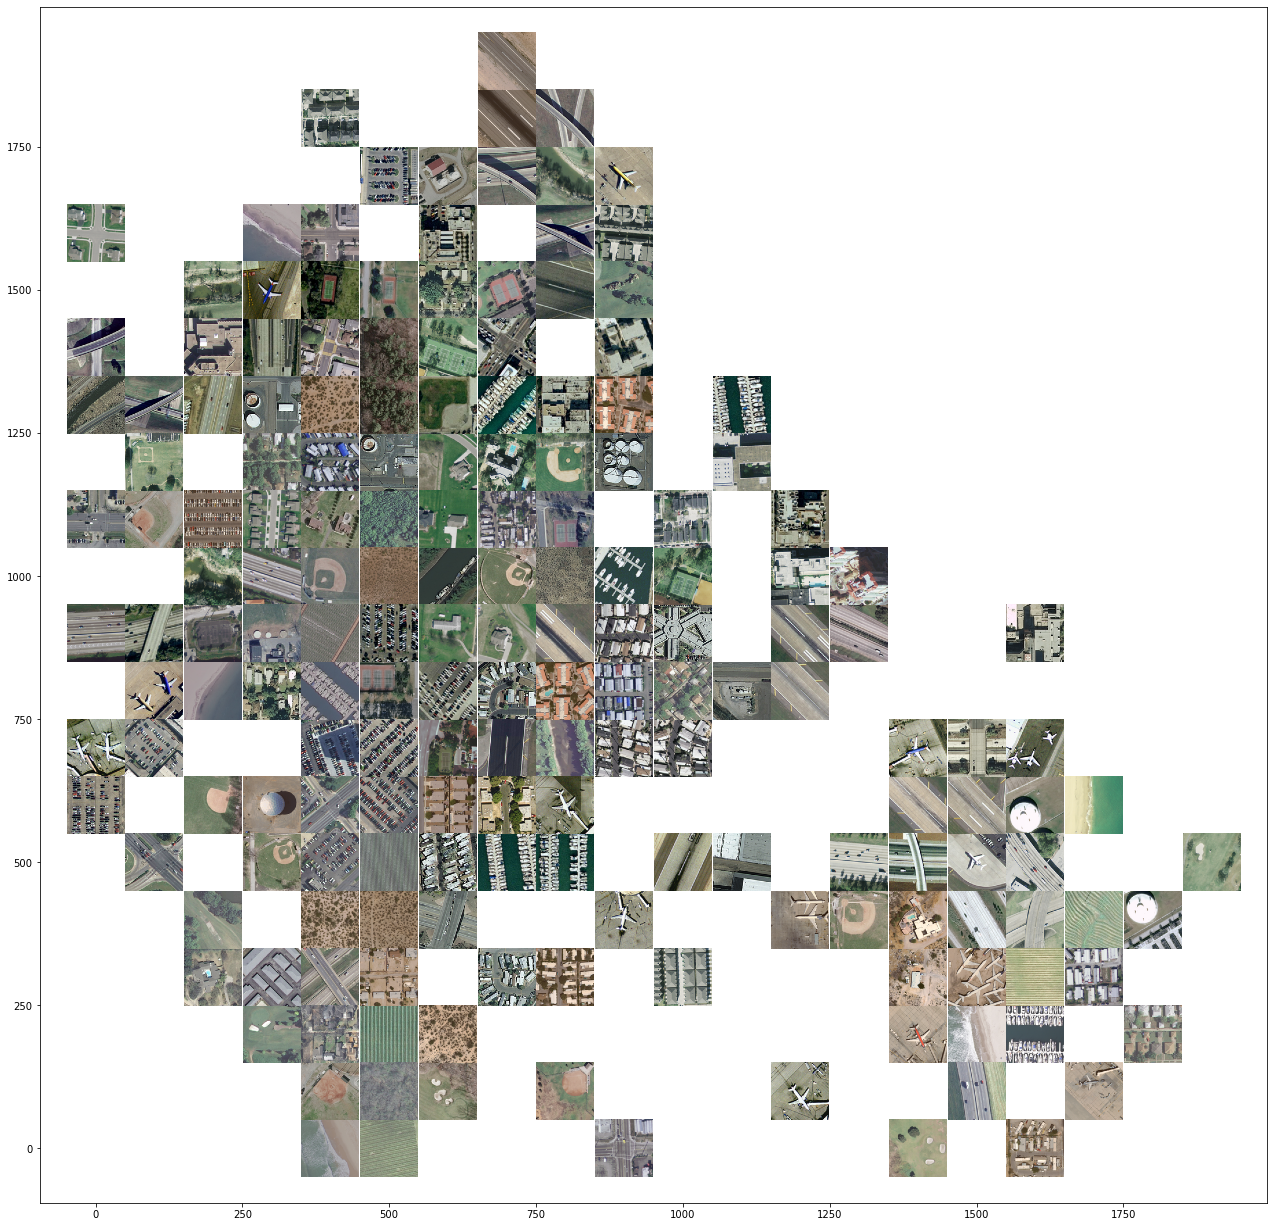

In [25]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            selected_filenames)